### Similar molecule retrieval

This module trains a model on one-hot encoded QM9 small molecule data, then uses it to
cluster the input data, then uses this clustering plus the trained model to retrieve
the most similar molecules from the training set, as determined by the approximated
kernel. Note that one-hot encoding is not a very informative way to represent a molecule,
so it's surprising the model performs as well as it does (MAE close to 1 kcal/mol!).
Retrieving the most similar molecules in the training set can give us some insight
into why the model makes the predictions it does (if they are unexpected, we might
want to reconsider the kernel function we are using and the definition of "similarity"
it implies).

Note that for this experiment, the raw data features are constructed in memory rather
than being saved in batches to disk and loaded as needed. As a result, this experiment
has a rather higher memory footprint than some; we don't recommend running this unless
you have >= 16 GB of RAM and a GPU (or if necessary modify it to load data in batches
rather than all at once). Also note that you'll need to run this out of Conda, because
it uses RDKit, which only works with Conda. Finally, note that the first time the
notebook is run, it will save the processed data, the trained model, etc., so that it
will take much less time to run if re-run later.

In [1]:
import os
import shutil
import time
import subprocess
import random

import wget
import tarfile
import ase
from ase.io import read
import pandas as pd
import numpy as np
import cupy as cp
import rdkit
import pickle
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from xGPR.visualization_tools.kernel_xpca import kernel_xPCA
from xGPR.xGP_Regression import xGPRegression as xGPReg
from xGPR.data_handling.dataset_builder import build_online_dataset

current_dir = os.getcwd()

if "chemdata" not in os.getcwd():
    os.chdir(os.path.join("..", "..", "benchmark_evals", "chemdata"))

In [2]:
os.chdir("cleaned_qm9_mols")
xfiles = [os.path.abspath(f) for f in os.listdir()]
xfiles.sort()

#The common practice for this in the literature
#has been to use 110,000 mols for training,
#remainder for test & validation. We'll follow
#that here.
random.seed(123)
random.shuffle(xfiles)

train_x, test_x = xfiles[:110000], xfiles[110000:]

os.chdir("..")

labels = pd.read_csv("qm9_.csv")
mol_dict = { k.split("_")[-1]:v for (k,v) in zip(labels.mol_id.tolist(), labels.u298_atom.tolist())} 
smiles_dict = { k.split("_")[-1]:v for (k,v) in zip(labels.mol_id.tolist(), labels.smiles.tolist())} 

os.chdir(current_dir)

In [3]:
def encode_mols(x_file_list, y_value_dict, smiles_dict, chunk_size, ftype = "train"):
    x, y, smiles = [], [], []

    atom_key = {"H":0, "C":1, "O":2, "N":3, "F":4}
    num_atom_types = len(atom_key)
    max_partners = 15
    
    for xfile in x_file_list:
        #Each molecule has up to 29 atoms
        output_mat = np.zeros((29, num_atom_types * max_partners), dtype=np.float32)

        mol = read(xfile)
        f_key = str(int(xfile.split("_")[-1].split(".xyz")[0]))
        y.append(y_value_dict[f_key])
        smiles.append(smiles_dict[f_key])

        positions, symbols = mol.get_positions(), mol.get_chemical_symbols()
        dist_mat = distance_matrix(positions, positions)
        idx_by_dist = np.argsort(dist_mat, axis=1)

        for i, symbol in enumerate(symbols):
            #One-hot encode the central atom
            output_mat[i,atom_key[symbol]] = 1
            for j, idx in enumerate(idx_by_dist[i,1:max_partners].tolist()):
                atom_offset = (j + 1) * num_atom_types + atom_key[symbols[idx]]
                output_mat[i, atom_offset] = 1 / dist_mat[i,idx]**6

        x.append(output_mat)

    x = np.stack(x)
    y = np.asarray(y)
    return x, y, smiles

In [4]:
#We now encode all the raw data...this might take a minute. Note that we build the dataset
#IN MEMORY, which has a non-negligible footprint.
if "training_data.pk" not in os.listdir():
    train_x, train_y, train_smiles = encode_mols(train_x, mol_dict, 
                                                         smiles_dict, chunk_size = 1000, ftype="train")
    training_data = {"x":train_x, "y":train_y, "smiles":train_smiles}
    with open("training_data.pk", "wb") as fhandle:
        pickle.dump(training_data, fhandle)
else:
    with open("training_data.pk", "rb") as fhandle:
        training_data = pickle.load(fhandle)
    train_x, train_y, train_smiles = training_data["x"], training_data["y"],\
            training_data["smiles"]
    
if "testing_data.pk" not in os.listdir():
    test_x, test_y, test_smiles = encode_mols(test_x, mol_dict, 
                                                      smiles_dict, chunk_size = 1000, ftype="test")
    testing_data = {"x":test_x, "y":test_y, "smiles":test_smiles}
    with open("testing_data.pk", "wb") as fhandle:
        pickle.dump(testing_data, fhandle)
else:
    with open("testing_data.pk", "rb") as fhandle:
        testing_data = pickle.load(fhandle)
    test_x, test_y, test_smiles = testing_data["x"], testing_data["y"],\
            testing_data["smiles"]

In [5]:
train_dset = build_online_dataset(train_x.astype(np.float64),
                                  train_y.astype(np.float64), chunk_size = 1000)

if "My_Molecular_Model.pk" not in os.listdir():
    #Use hyperparameters from a previous training session.
    hparams = np.array([-4.76942223, -1.04819144,  2.38732021])
    init_model = xGPReg(training_rffs = 2048, fitting_rffs = 16384, variance_rffs = 1024,
                   kernel_choice = "GraphRBF", verbose = True,
                   device = "gpu")

    preconditioner, ratio = init_model.build_preconditioner(train_dset, max_rank = 1500,
                                                      method = "srht_2",
                                                       preset_hyperparams = hparams)

    init_model.fit(train_dset, preconditioner = preconditioner, mode = 'cg',
             max_iter = 500, tol=1e-7,
              preset_hyperparams = hparams)

    with open("My_Molecular_Model.pk", "wb") as fhandle:
        pickle.dump(init_model, fhandle)
        
else:
    with open("My_Molecular_Model.pk", "rb") as fhandle:
        init_model = pickle.load(fhandle)

In [6]:
if "kxpca.pk" not in os.listdir():
    kxpca = kernel_xPCA(train_dset, init_model, n_components=500)
    with open("kxpca.pk", "wb") as fhandle:
        pickle.dump(kxpca, fhandle)
else:
    with open("kxpca.pk", "rb") as fhandle:
        kxpca = pickle.load(fhandle)

In [7]:
#Note that making predictions using kxpca is more expensive than making
#predictions using the model, because it requires first generating model
#predictions then compressing them.
if "XCOMP.npy" not in os.listdir():
    xcomp = kxpca.predict(train_x, chunk_size=1000)
    np.save("XCOMP.npy", xcomp)
else:
    xcomp = np.load("XCOMP.npy")

if "PREDS.npy" not in os.listdir():
    preds = init_model.predict(train_x, get_var=False, chunk_size=1000)
    np.save("PREDS.npy", preds)
else:
    preds = np.load("PREDS.npy")

Text(0, 0.5, 'Principal component 2')

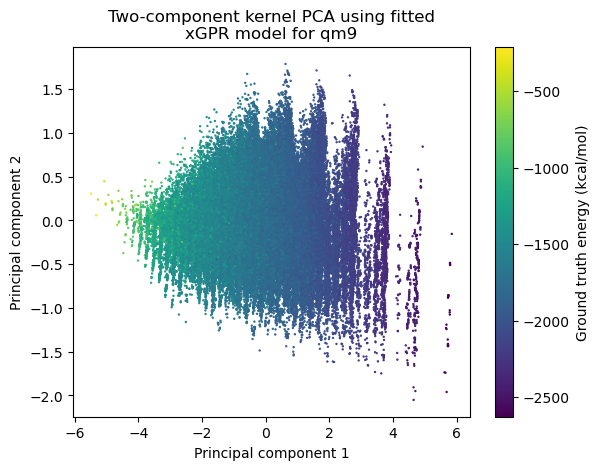

In [8]:
import seaborn as sns
plt.scatter(xcomp[:,0], xcomp[:,1], c=train_y, s=0.5)

plt.colorbar(label="Ground truth energy (kcal/mol)")
plt.title("Two-component kernel PCA using fitted\n"
          "xGPR model for qm9")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

In [9]:
#The next step entails clustering a 130,000 datapoint, 500d dataset on CPU using k-means.
#This can be a little slow. The scores are saved so this step need not be repeated
#if the notebook is run 2x.

from sklearn.cluster import KMeans as kmm
from sklearn import metrics


if "scores.npy" not in os.listdir():
    scores = []
    for nclust in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]:
        km = kmm(n_clusters=nclust, n_init=3)
        km.fit(xcomp)
        scores.append(km.inertia_)
        print(nclust)
    np.save("scores.npy", np.array(scores))

else:
    scores = np.load("scores.npy")

Text(0, 0.5, 'Sum squared error')

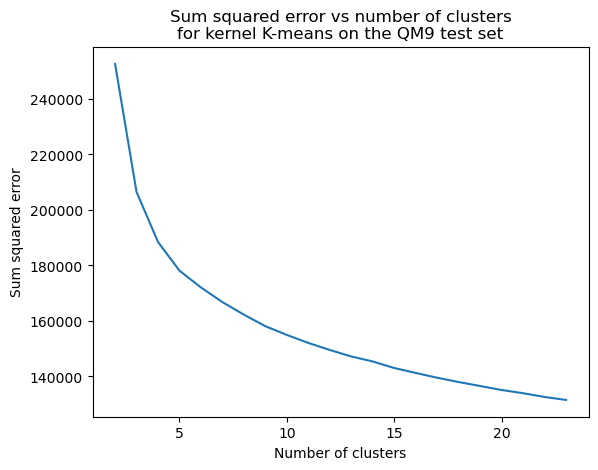

In [10]:
plt.plot(np.arange(2,24), scores)
plt.title("Sum squared error vs number of clusters\nfor kernel K-means on the QM9 test set")
plt.xlabel("Number of clusters")
plt.ylabel("Sum squared error")

In [11]:
km = kmm(n_clusters=5, n_init=5, random_state=123)
km.fit(xcomp)

KMeans(n_clusters=5, n_init=5, random_state=123)

Text(0.5, 0, 'Cluster number')

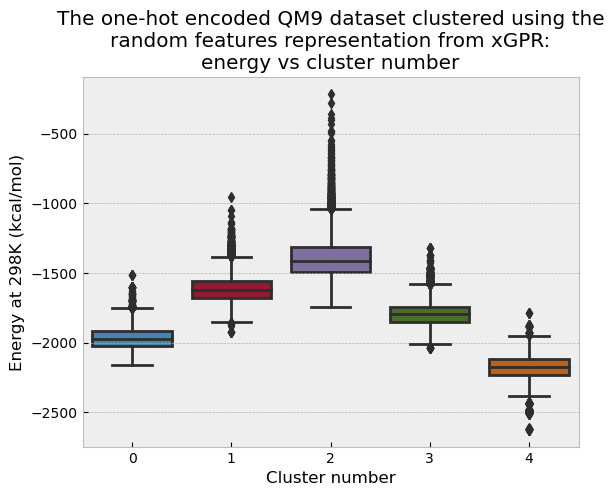

In [12]:
plt.style.use("bmh")
sns.boxplot(x=km.labels_, y=train_y)
plt.title("The one-hot encoded QM9 dataset clustered using the\nrandom features representation from xGPR:\nenergy vs cluster number")
plt.ylabel("Energy at 298K (kcal/mol)")
plt.xlabel("Cluster number")

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

#OK, we've clustered the input data. Now let's randomly pick five molecules FROM THE TEST SET
#and determine which molecules IN THE TRAINING SET are most similar.

rng = np.random.default_rng(123)
picked_idx = rng.choice(len(test_smiles), size=5)
picked_smiles = [test_smiles[i] for i in picked_idx]

picked_idx = np.array(picked_idx)

picked_x = test_x[picked_idx,:,:]
picked_y = test_y[picked_idx]
picked_kx = kxpca.predict(picked_x)

picked_reps = init_model.kernel.transform_x(cp.asarray(picked_x))

In [14]:
#Assign the selected molecules to clusters, and then use this
#to find the closest molecules in the training set.
picked_labels = km.predict(picked_kx)
n_to_retrieve = 50
retrieved_smiles = []

for i, picked_label in enumerate(picked_labels):
    relevant_idx = (km.labels_ == picked_label)
    relevant_train_x = train_x[relevant_idx,...]
    relevant_idx = np.where(relevant_idx == True)[0].tolist()
    relevant_smiles = [train_smiles[j] for j in relevant_idx]
    dist_list = []

    for j in range(0, relevant_train_x.shape[0], 1000):
        x_batch = relevant_train_x[j:j+1000,...]
        x_feats = init_model.kernel.transform_x(cp.asarray(x_batch))
        dists = cp.asnumpy((picked_reps[i:i+1,...] * x_feats).sum(axis=1))
        dist_list.append(dists)

    dist_list = np.concatenate(dist_list)
    top_idx = np.argsort(dist_list)[-n_to_retrieve:].tolist()
    relevant_smiles = [relevant_smiles[j] for j in top_idx]
    retrieved_smiles.append(relevant_smiles)
    print(f"{i} complete")

0 complete
1 complete
2 complete
3 complete
4 complete


In [15]:
from rdkit.Chem import Draw
for i, (picked_smi, retrieved_smi) in enumerate(zip(picked_smiles, retrieved_smiles)):
    m_picked = Chem.MolFromSmiles(picked_smi)
    Draw.MolToFile(m_picked, f"Selected_molecule_{i}.png")

    retrieved_mols = [Chem.MolFromSmiles(smi) for smi in retrieved_smi]
    img = Draw.MolsToGridImage(retrieved_mols, molsPerRow=8,
                             subImgSize=(200,200), returnPNG=False)
    img.save(f"Retrieved_training_set_mols_for_{i}.png") 